In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
%cd /content

In [ ]:
# copy data
!mkdir ./data
!cp drive/MyDrive/AI\ poster/LA.zip ./data/
%cd ./data
!unzip LA.zip
!ls

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

In [ ]:

import torchaudio
import matplotlib.pyplot as plt
import requests

import matplotlib.pyplot as plt
import numpy as np
import os

import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)


Device: cuda


Shape of waveform: torch.Size([1, 32366])
Sample rate of waveform: 16000


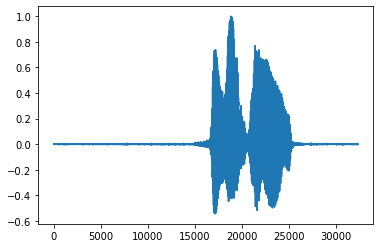

In [ ]:

filename = 'LA/ASVspoof2019_LA_train/flac/LA_T_8184669.flac'
waveform, sample_rate = torchaudio.load(filename)

print('Shape of waveform: {}'.format(waveform.size()))
print('Sample rate of waveform: {}'.format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

Shape of spectrogram: torch.Size([1, 196, 166])
Shape of spectrogram: torch.Size([1, 196, 166])


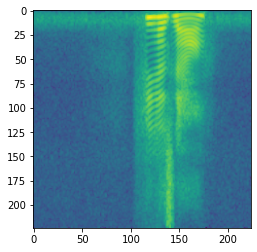

In [ ]:
# Spectrogram
specgram = torchaudio.transforms.Spectrogram(n_fft=390)(waveform)
print('Shape of spectrogram:', specgram.size())

import torchvision.transforms as T
transform = T.Compose([T.Resize((224,224))])
specgram1 = transform(specgram)

# print(specgram)
print('Shape of spectrogram:', specgram.size())
plt.figure()
plt.imshow(specgram1.log2()[0, :, :].numpy())
plt.show()

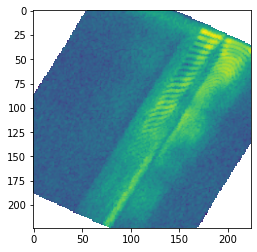

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:

transform2 = T.Compose([T.RandomRotation((-30,30), expand=False),T.Resize((224,224))])
specgram2 = transform2(specgram)
plt.figure()
plt.imshow(specgram2.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram2.size())


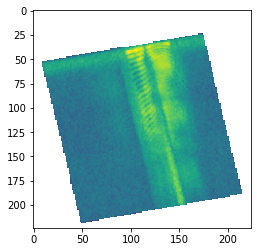

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:
transform3 = T.Compose([T.RandomAffine(degrees=(-50,50), translate=(0, 0.1), scale=(0.7, 0.8), shear=(0,0)),T.Resize((224,224))])
specgram3 = transform3(specgram)
plt.figure()
plt.imshow(specgram3.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram3.size())


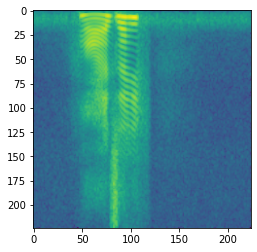

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:
transform4 = T.Compose([T.RandomHorizontalFlip(p=1),T.Resize((224,224))])
specgram4 = transform4(specgram)
plt.figure()
plt.imshow(specgram4.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram4.size())


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random

def label_dct_loader(path):
  label_dct = {}
  n = 0
  with open(path,'r') as f:
    for line in f:
      line=line.split()
      if line[4] == 'bonafide':
        label_dct[line[1]]= 1
      else:
        label_dct[line[1]]= 0
  print(label_dct)
  return label_dct

def flac_loader(path,label_dct,test=False):
    print(path)
    specgram_lst = []
    specgram_name = []
    label = []
    switch = 1
    bonafide = 0
    spoof = 0
    count = 0
    dir_list = os.listdir(path)
    transform = T.Compose([T.Resize((224,224))])

    random.seed(0)
    random.shuffle(dir_list)
    for fileName in dir_list:
      if switch: # 測試時控制數據集大小
        dataName = fileName.split('.')[0]
        if dataName in label_dct: # Label中缺少部分wav檔案
          waveform, sample_rate = torchaudio.load(path+"/"+fileName)
          specgram = torchaudio.transforms.Spectrogram(n_fft=390)(waveform)
          if label_dct[dataName] == 1 : # bonafaid 需要增加十倍資料數量
            specgram1 = transform(specgram)
            specgram_lst.append(specgram1)
            # specgram2 = transform2(specgram)
            # specgram_lst.append(specgram2)
            # specgram3 = transform3(specgram)
            # specgram_lst.append(specgram3)
            # specgram4 = transform4(specgram)
            # specgram_lst.append(specgram4)
            for _ in range(1):
              # specgram_name.append(dataName)
              label.append(1)
              bonafide += 1
          elif spoof <= 3000: # spoof 不需要增加資料量
            specgram = transform(specgram)
            specgram_lst.append(specgram)
            # specgram_name.append(dataName)
            label.append(0)
            spoof += 1
        count +=1
        if test is True and count == 2000:
          switch = 0
    print(f'圖片數量: B:{bonafide},S: {spoof} Total: {bonafide+spoof} ')
    return specgram_lst, label


class customDataset(Dataset):
    def __init__(self, data_path, label_path, mode= "spoof"):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.label_dct = label_dct_loader(label_path)
        self.data, self.label = flac_loader(data_path,self.label_dct)
        # self.label = label_maker(self.label_dct, self.data_lst)
        print(f'Dataset data: {len(self.data)}, Dataset label:{len(self.label)}')

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        return self.data[index], self.label[index]

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.label)

In [ ]:
batch_size = 8

data_path = 'LA/ASVspoof2019_LA_train/flac'
eval_path = 'LA/ASVspoof2019_LA_eval/flac'
label_path = 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
eval_label_path = 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'


train_data_dset = customDataset(data_path, label_path)
eval_data_dset = customDataset(eval_path, eval_label_path)

train_datas = DataLoader(train_data_dset, batch_size=batch_size, shuffle=True)
eval_datas = DataLoader(eval_data_dset, batch_size=batch_size, shuffle=True)


In [ ]:
print(eval_data_dset[1:2])
len(eval_data_dset)

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
  def __init__(self):
      super().__init__()
      # 4 conv/ flatten / linear / softmax
      # N x 1 x 224 x 224
      self.conv1 = nn.Sequential(
          nn.Conv2d(
              in_channels=1,
              out_channels=16,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=16,
              out_channels=16,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 16 x 112 x 112
      self.conv2 = nn.Sequential(
          nn.Conv2d(
              in_channels=16,
              out_channels=32,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=32,
              out_channels=32,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 32 x 56 x 56
      self.conv3 = nn.Sequential(
          nn.Conv2d(
              in_channels=32,
              out_channels=64,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),

      # N x 64 x 28 x 28
          nn.Conv2d(
              in_channels=64,
              out_channels=64,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 64 x 14 x 14
      self.conv4 = nn.Sequential(
          nn.Conv2d(
              in_channels=64,
              out_channels=128,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      # N x 128 x 7 x 7
          nn.Conv2d(
              in_channels=128,
              out_channels=128,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(128),
          nn.ReLU(),
      )
      # N x 128 x 7 x 7
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(6272, 2)

  def forward(self, input_data):
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flatten(x)
    predictions = self.linear(x)
    return predictions

In [ ]:
import torch.optim as optim
model = CNN()
model.to(device)

from torchsummary import summary
summary(model, (1,224,224))

In [ ]:
def evaluate(model, total_vals):
  model.eval()
  with torch.no_grad():
    total_acc = 0
    for mini_x, mini_y in total_vals:
      mini_x = mini_x.to(device)
      mini_y = mini_y.to(device)
      scores = model(mini_x)
      predictions = scores.max(1)[1]
      acc = predictions.eq(mini_y).sum().item()
      total_acc += acc
    print("Acc", total_acc/len(eval_data_dset))

In [ ]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
PRINT_EVERY = 40
for epoch in range(NUM_EPOCHS):
  sum_loss = 0
  for counter, (mini_train_x,mini_train_y) in enumerate(train_datas):
    mini_train_x, mini_train_y = mini_train_x.to(device), mini_train_y.to(device)
    prediction = model(mini_train_x)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(prediction, mini_train_y)
    if counter % PRINT_EVERY == 0 and counter !=0:
      print(f'EPOCH: {epoch +1}: {sum_loss/counter}')
      sum_loss = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    sum_loss += loss.item()
  evaluate(model,eval_datas)

EPOCH: 1: 1.3231970630586147
EPOCH: 1: 0.43004683312028646
EPOCH: 1: 0.32754425033926965
EPOCH: 1: 0.22276961524039507
EPOCH: 1: 0.16028311476111412
EPOCH: 1: 0.12951214127242566
EPOCH: 1: 0.11686074488929339
EPOCH: 1: 0.10101172649301589
EPOCH: 1: 0.08504545378188293
EPOCH: 1: 0.07724072147160768
EPOCH: 1: 0.07842128385197032
EPOCH: 1: 0.07512511145323515
EPOCH: 1: 0.059407493013602035
EPOCH: 1: 0.049726900405117444
EPOCH: 1: 0.04847735139230887
EPOCH: 1: 0.051900056158774535
EPOCH: 1: 0.0463653749841101
Acc 0.6145787221484432
EPOCH: 2: 0.8807509243488312
EPOCH: 2: 0.31347818300127983
EPOCH: 2: 0.1946086826423804
EPOCH: 2: 0.1663476420333609
EPOCH: 2: 0.18021062998101114
EPOCH: 2: 0.11769553277020653
EPOCH: 2: 0.07879176488412278
EPOCH: 2: 0.08856333464354975
EPOCH: 2: 0.05849146197950985
EPOCH: 2: 0.06848791787400842
EPOCH: 2: 0.05618772730231285
EPOCH: 2: 0.054212199593894186
EPOCH: 2: 0.04125005029625474
EPOCH: 2: 0.038411362462544014
EPOCH: 2: 0.04006346438700954
EPOCH: 2: 0.03741